# Ch09

In [1]:
import numpy as np 
import pandas as pd 

from adv_finance.model_selection import PurgedKFold

In [2]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

# 9.2 GridSearchCV

In [3]:
class MyPipeline(Pipeline):
    def fit(self, X, y, sample_weight=None, **fit_params):
        if sample_weight is not None:
            fit_params[self.steps[-1][0] + '__sample_weight'] = sample_weight
        return super(MyPipeline, self).fit(X, y, **fit_params)


def clf_hyper_fit(feat, label, t1, pipe_clf, search_params, scoring=None,
                  n_splits=3, bagging=[0, None, 1.],
                  rnd_search_iter=0, n_jobs=-1, pct_embargo=0., **fit_params):
    # Set defaut value for scoring
    if scoring is None:
        if set(label.values) == {0, 1}:
            scoring = 'f1'
        else:
            scoring = 'neg_log_loss'
    # HP serach on traing data
    inner_cv = PurgedKFold(n_splits=n_splits, t1=t1, pct_embargo=pct_embargo)
    if rnd_search_iter == 0:
        search = GridSearchCV(estimator=pipe_clf, param_grid=search_params,
                              scoring=scoring, cv=inner_cv, n_jobs=n_jobs, iid=False)
    else:
        search = RandomizedSearchCV(estimator=pipe_clf, param_distributions=search_params,
                                    scoring=scoring, cv=inner_cv, n_jobs=n_jobs, iid=False)
    best_pipe = search.fit(feat, label, **fit_params).best_estimator_
    # Fit validated model on the entirely of dawta
    if bagging[0] > 0:
        bag_est = BaggingClassifier(base_estimator=MyPipeline(best_pipe.steps),
                                   n_estimators=int(bagging[0]), max_samples=float(bagging[1]),
                                   max_features=float(bagging[2]), n_jobs=n_jobs)
        bag_est = best_pipe.fit(feat, label,
                                sample_weight=fit_params[bag_est.base_estimator.steps[-1][0] + '__sample_weight'])
        best_pipe = Pipeline([('bag', bag_est)])
    return best_pipe



In [4]:
from adv_finance.datasets import get_cls_data

In [5]:
X, label = get_cls_data(n_features=10, n_informative=5, n_redundant=0, n_samples=10000)
print(X.head())
print(label.head())

                                 I_0       I_1       I_2       I_3       I_4  \
1981-02-13 13:23:09.409844  2.105359  2.861661  0.104159  0.686149  1.369429   
1981-02-16 13:23:09.409844 -0.330754  1.464379 -1.405119  0.396713 -1.722305   
1981-02-17 13:23:09.409844 -0.461334 -0.160432 -2.169501 -0.137535  0.398229   
1981-02-18 13:23:09.409844 -1.573667  3.110105  0.073939  1.232501  1.069429   
1981-02-19 13:23:09.409844  0.528677  1.538982 -1.603758  2.056413  0.777722   

                                 N_0       N_1       N_2       N_3       N_4  
1981-02-13 13:23:09.409844 -0.868903 -1.297125 -0.160205 -0.481024  0.841338  
1981-02-16 13:23:09.409844  0.471952 -1.443687 -0.433773  0.123114 -0.102970  
1981-02-17 13:23:09.409844 -0.278979 -1.860566  0.909540 -0.396742  2.455228  
1981-02-18 13:23:09.409844  0.700720 -1.097145  0.157145 -1.699373  1.167458  
1981-02-19 13:23:09.409844 -0.644594 -0.304476  0.682256 -0.644368  0.280994  
                            bin       w      

/nfs/code/adv_finance/adv_finance/datasets/generate.py:10: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  end=pd.datetime.today())


In [6]:
%%time 

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

name = 'svc'
params_grid = {name + '__C': [1e-2, 1e-1, 1, 10, 100], name + '__gamma': [1e-2, 1e-1, 1, 10, 100]}
kernel = 'rbf'
clf = SVC(kernel=kernel, probability=True)
pipe_clf = Pipeline([(name, clf)])
fit_params = dict()

clf = clf_hyper_fit(X, label['bin'], t1=label['t1'], pipe_clf=pipe_clf, scoring='neg_log_loss',
                    search_params=params_grid, n_splits=3, bagging=[0, None, 1.],
                    rnd_search_iter=0, n_jobs=-1, pct_embargo=0., **fit_params)

CPU times: user 4min 19s, sys: 1.46 s, total: 4min 20s
Wall time: 6min 35s


In [8]:
clf

Pipeline(memory=None,
     steps=[('svc', SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

# 9.3 RandomizedSearchCV

In [15]:
from scipy.stats import rv_continuous, kstest
import matplotlib.pyplot as mpl 

class LogUniformGen(rv_continuous):
    def _cdf(self, x):
        return np.log(x / self.a) / np.log(self.b / self.a)
    
def log_uniform(a=1, b=np.exp(1)):
    return LogUniformGen(a=a, b=b, name='log_uniform')


In [16]:
# Snippet 9.4 LogUniform Plot 

a, b, size = 1E-3, 1E3, 10000
vals = log_uniform(a=a, b=b).rvs(size=size)
print( kstest(rvs=np.log(vals), cdf='uniform', args=(np.log(a), np.log(b/a)), N=size) )


KstestResult(statistic=0.009496368416805123, pvalue=0.32793156330100465)


count    10000.000000
mean        75.872090
std        181.348983
min          0.001002
25%          0.033603
50%          1.060011
75%         32.901172
max        999.955627
dtype: float64


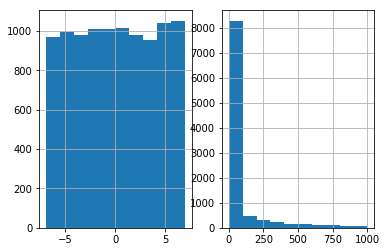

In [18]:

print( pd.Series(vals).describe() )
mpl.subplot(121)
pd.Series(np.log(vals)).hist() 
mpl.subplot(122)
pd.Series(vals).hist() 
mpl.show()



In [11]:
%%time 

name = 'svc'
params_dist = {name + '__C': log_uniform(a=1e-2, b=1e2),
               name + '__gamma': log_uniform(a=1e-2, b=1e2)}
kernel = 'rbf'
clf = SVC(kernel=kernel, probability=True)
pipe_clf = Pipeline([(name, clf)])
fit_params = dict()

clf = clf_hyper_fit(X, label['bin'], t1=label['t1'], pipe_clf=pipe_clf, scoring='neg_log_loss',
                    search_params=params_grid, n_splits=3, bagging=[0, None, 1.],
                    rnd_search_iter=25, n_jobs=-1, pct_embargo=0., **fit_params)

CPU times: user 4min 20s, sys: 539 ms, total: 4min 20s
Wall time: 5min 17s


In [12]:
clf

Pipeline(memory=None,
     steps=[('svc', SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])